# Loading the data

In [1]:
import pandas as pd
df_automotive = pd.read_csv('reviews_Automotive_5.csv')

In [2]:
df_automotive['tag'] = 'automotive'

In [3]:
automotive = df_automotive[['reviewText','tag']]

In [4]:
df_beauty = pd.read_csv('reviews_Beauty_5.csv')
df_beauty['tag'] = 'beauty'
beauty = df_beauty[['reviewText','tag']]

In [5]:
df_clothingShoesJewelry = pd.read_csv('reviews_Clothing_Shoes_and_Jewelry_5.csv')
df_clothingShoesJewelry['tag'] = 'clothingShoesJewelry'
clothingShoesJewelry = df_clothingShoesJewelry[['reviewText','tag']]

In [6]:
df_electronics = pd.read_csv('reviews_Electronics_5.csv')
df_electronics['tag'] = 'electronics'
electronics = df_electronics[['reviewText','tag']]

In [7]:
df_homeKitchen = pd.read_csv('reviews_Home_and_Kitchen_5.csv')
df_homeKitchen['tag'] = 'homeKitchen'
homeKitchen = df_homeKitchen[['reviewText','tag']]

In [8]:
reviews = pd.concat([automotive,beauty,clothingShoesJewelry,electronics,homeKitchen],ignore_index=True)

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
reviewText    49983 non-null object
tag           50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [10]:
reviews.describe()

,reviewText,tag
count,49983,50000
unique,49982,5
top,Good,electronics
freq,2,10000


# Preprocess reviews

In [11]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models
import gensim

C:\Users\rimo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
nltk_stpwd = stopwords.words('english')
stop_words_stpwd = get_stop_words('en')
merged_stopwords = list(set(nltk_stpwd + stop_words_stpwd))

In [14]:
sb_stemmer = SnowballStemmer('english')

In [15]:
num_reviews = reviews.shape[0]

doc_set = [reviews.reviewText[i] for i in range(num_reviews)]

texts = []

for doc in doc_set:
    if type(doc) is str:
        tokens = tokenizer.tokenize(doc.lower())
        stopped_tokens = [token for token in tokens if not token in merged_stopwords]
        stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
        texts.append(stemmed_tokens)

In [16]:
len(texts)

49983

# Transforming tokenized documents into an id-term dictionary

In [17]:
texts_dict = gensim.corpora.Dictionary(texts)
texts_dict.save('reviews.dict')
# Examine each token’s unique id
print(texts_dict)

Dictionary(39692 unique tokens: ['acidiccon', 'afullmark', 'barley', 'becom', 'behind']...)


In [18]:
import operator
texts_dict.filter_extremes(no_below=30, no_above=0.15) # inlace filter
print(texts_dict)
print("top terms:")
print(sorted(texts_dict.token2id.items(), key=operator.itemgetter(1), reverse = False)[:10])

Dictionary(4267 unique tokens: ['becom', 'behind', 'bottl', 'brush', 'clean']...)
top terms:
[('becom', 0), ('behind', 1), ('bottl', 2), ('brush', 3), ('clean', 4), ('complic', 5), ('dirt', 6), ('easi', 7), ('enough', 8), ('even', 9)]


# Creating bag of words

In [19]:
corpus = [texts_dict.doc2bow(text) for text in texts]
len(corpus)

49983

In [20]:
gensim.corpora.MmCorpus.serialize('reviews.mm', corpus)

# Training an LDA model

In [21]:
import random
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]
ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    ldamodels_bow[i] = gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=texts_dict,passes=4)
    ldamodels_bow[i].save('ldamodels_bow_'+str(i)+'.lda')

C:\Users\rimo\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [22]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [25]:
import pickle
lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('lda_bow_topics.pkl','wb'))

In [26]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims

pickle.dump(lda_stability,open('lda_bow_stability.pkl','wb'))

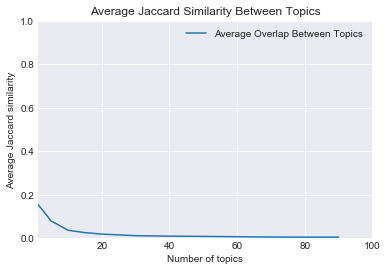

In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
lda_stability = pickle.load(open('lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

In [34]:
reviews['prediction'] = 10
for r in range(50000):
    doc = reviews.reviewText[r]
    if type(doc) is str:
        tokens = tokenizer.tokenize(doc.lower())
        stopped_tokens = [token for token in tokens if not token in merged_stopwords]
        stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
        bow_vector = texts_dict.doc2bow(stemmed_tokens)
        # transform into LDA space
        lda_vector = ldamodels_bow[10][bow_vector]
        reviews.prediction[r] = sorted(lda_vector, key=lambda item: item[1])[-1][0]

C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [35]:
reviews.to_csv('reviews_bow_prediction.csv')

# TF-IDF + LDA

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

ldamodels_tfidf = {}
for i in topicnums:
    random.seed(42)
    ldamodels_tfidf[i] = models.ldamodel.LdaModel(corpus_tfidf,num_topics=i,id2word=texts_dict)
    ldamodels_tfidf[i].save('ldamodels_tfidf_'+str(i)+'.lda')

C:\Users\rimo\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [37]:
lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_tfidf_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('lda_tfidf_topics.pkl','wb'))

In [38]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims

pickle.dump(lda_stability,open('lda_tfidf_stability.pkl','wb'))

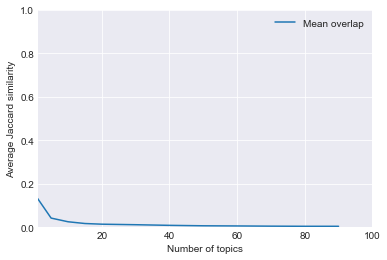

In [39]:
lda_stability = pickle.load(open('lda_tfidf_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    plt.legend()    
    plt.show()

In [45]:
reviews['predictionTfidf'] = 10
tokens = tokenizer.tokenize(reviews.reviewText[0].lower())
stopped_tokens = [token for token in tokens if not token in merged_stopwords]
stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
bow_vector = texts_dict.doc2bow(stemmed_tokens)
# transform into LDA space
lda_vector = ldamodels_tfidf[10][bow_vector]
reviews.predictionTfidf[0] = sorted(lda_vector, key=lambda item: item[1])[-1][0]

C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
print (reviews.predictionTfidf[0])

7


In [48]:
reviews['predictionTfidf'] = 10
for r in range(50000):
    doc = reviews.reviewText[r]
    if type(doc) is str:
        tokens = tokenizer.tokenize(doc.lower())
        stopped_tokens = [token for token in tokens if not token in merged_stopwords]
        stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
        bow_vector = texts_dict.doc2bow(stemmed_tokens)
        # transform into LDA space
        lda_vector = ldamodels_tfidf[10][bow_vector]
        reviews.predictionTfidf[r] = sorted(lda_vector, key=lambda item: item[1])[-1][0]

C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [49]:
reviews.to_csv('reviews_bow_prediction.csv')

# Model evaluation

In [73]:
def intra_inter(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[tfidf[dictionary.doc2bow(tokens[:int(len(tokens)/2)])]] for tokens in test_docs]
    part2 = [lda_model[tfidf[dictionary.doc2bow(tokens[int(len(tokens)/2):])]] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    # print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    # print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [75]:
print("LDA-BOW results:")
intra_inter(ldamodels_bow[10],texts_dict,texts)

LDA-BOW results:


(0.57717808120326, 0.30253227991187587)

In [76]:
print("LDA-TFIDF results:")
intra_inter(ldamodels_tfidf[10],texts_dict,texts)

LDA-TFIDF results:


(0.6145803706659262, 0.41381271613214266)

In [53]:
# For `num_topics` number of topics, return `num_words` most significant words
ldamodels_bow[10].show_topics(num_topics=10,num_words=50)

[(0,
  '0.018*"fit" + 0.010*"comfort" + 0.009*"pillow" + 0.008*"shoe" + 0.008*"top" + 0.008*"side" + 0.008*"size" + 0.007*"put" + 0.007*"littl" + 0.007*"around" + 0.007*"nice" + 0.007*"bed" + 0.007*"back" + 0.006*"also" + 0.006*"cover" + 0.006*"bit" + 0.005*"feel" + 0.005*"perfect" + 0.005*"floor" + 0.005*"wear" + 0.005*"need" + 0.005*"hold" + 0.005*"feet" + 0.005*"place" + 0.005*"enough" + 0.005*"easi" + 0.004*"bottom" + 0.004*"room" + 0.004*"made" + 0.004*"hang" + 0.004*"assembl" + 0.004*"go" + 0.004*"pad" + 0.004*"sheet" + 0.004*"keep" + 0.004*"way" + 0.004*"cute" + 0.004*"even" + 0.004*"right" + 0.004*"support" + 0.004*"roll" + 0.004*"mat" + 0.004*"plastic" + 0.003*"hole" + 0.003*"tight" + 0.003*"wide" + 0.003*"leg" + 0.003*"mold" + 0.003*"small" + 0.003*"sleep"'),
 (1,
  '0.017*"unit" + 0.012*"batteri" + 0.012*"camera" + 0.011*"power" + 0.011*"cabl" + 0.010*"drive" + 0.010*"set" + 0.010*"sound" + 0.009*"need" + 0.009*"devic" + 0.009*"connect" + 0.008*"plug" + 0.008*"tv" + 0.007*"c

In [56]:
ldamodels_tfidf[10].show_topics(num_topics=10,num_words=50)

[(0,
  '0.004*"easi" + 0.004*"unit" + 0.004*"need" + 0.003*"set" + 0.003*"price" + 0.003*"cabl" + 0.003*"2" + 0.003*"bought" + 0.003*"vacuum" + 0.003*"batteri" + 0.003*"purchas" + 0.003*"qualiti" + 0.003*"problem" + 0.003*"case" + 0.003*"year" + 0.003*"buy" + 0.003*"two" + 0.003*"oven" + 0.003*"much" + 0.003*"small" + 0.003*"want" + 0.003*"also" + 0.003*"replac" + 0.003*"sound" + 0.003*"bag" + 0.003*"thing" + 0.003*"littl" + 0.003*"power" + 0.002*"back" + 0.002*"perfect" + 0.002*"fit" + 0.002*"go" + 0.002*"item" + 0.002*"review" + 0.002*"room" + 0.002*"3" + 0.002*"nice" + 0.002*"1" + 0.002*"hold" + 0.002*"even" + 0.002*"drive" + 0.002*"new" + 0.002*"34" + 0.002*"size" + 0.002*"mattress" + 0.002*"take" + 0.002*"amazon" + 0.002*"got" + 0.002*"open" + 0.002*"put"'),
 (1,
  '0.055*"cook" + 0.054*"pan" + 0.027*"knife" + 0.020*"knive" + 0.016*"rice" + 0.014*"bowl" + 0.014*"gift" + 0.012*"recip" + 0.011*"lid" + 0.011*"fruit" + 0.010*"cooker" + 0.010*"boil" + 0.009*"hanger" + 0.008*"pour" + 0.

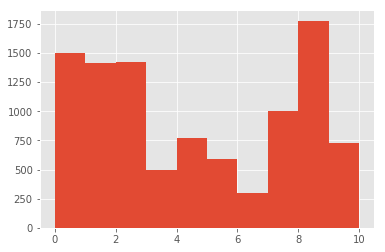

In [57]:
plt.style.use('ggplot')

automotive = reviews[reviews['tag']=='automotive']
automotive['prediction'].hist()

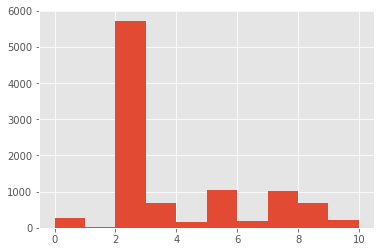

In [58]:
beauty = reviews[reviews['tag']=='beauty']
beauty['prediction'].hist()

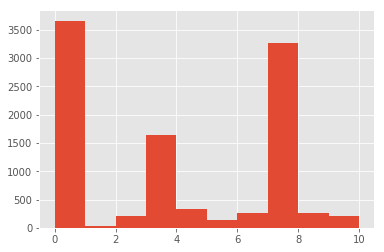

In [59]:
clothingShoesJewelry = reviews[reviews['tag']=='clothingShoesJewelry']
clothingShoesJewelry['prediction'].hist()

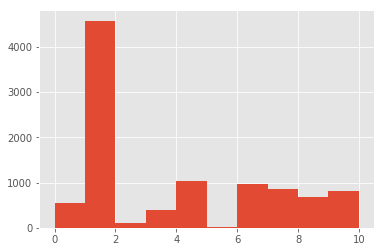

In [60]:
electronics = reviews[reviews['tag']=='electronics']
electronics['prediction'].hist()

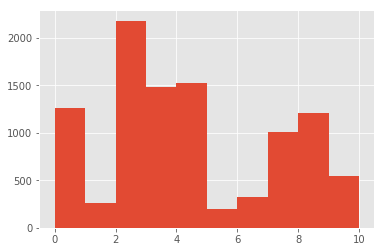

In [61]:
homeKitchen = reviews[reviews['tag']=='homeKitchen']
homeKitchen['prediction'].hist()

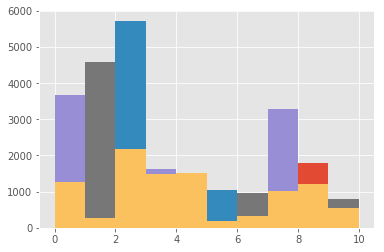

In [77]:
automotive['prediction'].hist()
beauty['prediction'].hist()
clothingShoesJewelry['prediction'].hist()
electronics['prediction'].hist()
homeKitchen['prediction'].hist()

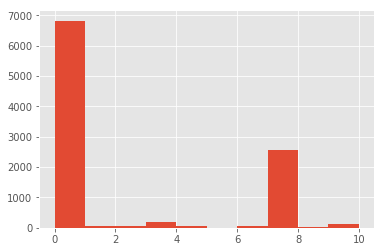

In [78]:
automotive['predictionTfidf'].hist()

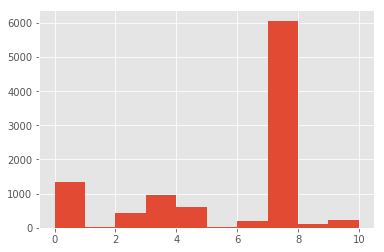

In [79]:
beauty['predictionTfidf'].hist()

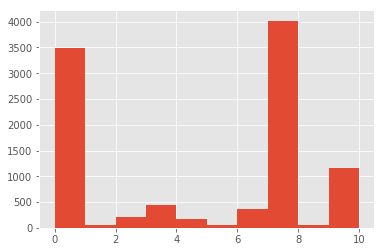

In [80]:
clothingShoesJewelry['predictionTfidf'].hist()

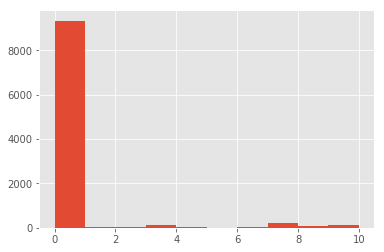

In [81]:
electronics['predictionTfidf'].hist()

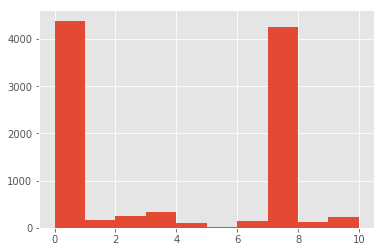

In [82]:
homeKitchen['predictionTfidf'].hist()

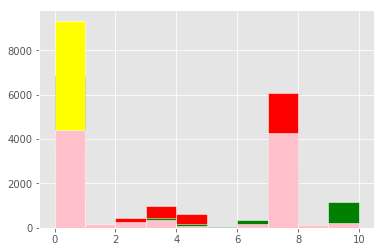

In [272]:
automotive['predictionTfidf'].hist(color = "skyblue", ec="black")
beauty['predictionTfidf'].hist(color = "red", ec="white")
clothingShoesJewelry['predictionTfidf'].hist(color = "green", ec="white")
electronics['predictionTfidf'].hist(color = "yellow", ec="white")
homeKitchen['predictionTfidf'].hist(color = "pink", ec="white")

Querying the LDA Model

In [206]:
raw_query = 'Ultra HD TV'

query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!
    
print (query)

['ultra', 'hd', 'tv']


In [207]:
# translate words in query to ids and frequencies. 
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [208]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print(query)

[(338, 1), (845, 1), (2761, 1)]


In [209]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(0, 0.025),
 (3, 0.025),
 (4, 0.025),
 (9, 0.025000371),
 (2, 0.025000859),
 (7, 0.0250024),
 (8, 0.025002602),
 (5, 0.025008768),
 (6, 0.2864322),
 (1, 0.5135528)]

In [210]:
ldamodels_bow[10].print_topic(a[0][0]) #least related

'0.018*"fit" + 0.010*"comfort" + 0.009*"pillow" + 0.008*"shoe" + 0.008*"top" + 0.008*"side" + 0.008*"size" + 0.007*"put" + 0.007*"littl" + 0.007*"around"'

In [211]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.017*"unit" + 0.012*"batteri" + 0.012*"camera" + 0.011*"power" + 0.011*"cabl" + 0.010*"drive" + 0.010*"set" + 0.010*"sound" + 0.009*"need" + 0.009*"devic"'

In [212]:
a = list(sorted(ldamodels_tfidf[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(1, 0.025),
 (4, 0.025),
 (6, 0.025),
 (9, 0.025),
 (5, 0.025000032),
 (2, 0.025000043),
 (8, 0.025000125),
 (7, 0.02500073),
 (3, 0.025000816),
 (0, 0.77499825)]

In [213]:
ldamodels_tfidf[10].print_topic(a[0][0]) #least related

'0.055*"cook" + 0.054*"pan" + 0.027*"knife" + 0.020*"knive" + 0.016*"rice" + 0.014*"bowl" + 0.014*"gift" + 0.012*"recip" + 0.011*"lid" + 0.011*"fruit"'

In [215]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.018*"fit" + 0.010*"comfort" + 0.009*"pillow" + 0.008*"shoe" + 0.008*"top" + 0.008*"side" + 0.008*"size" + 0.007*"put" + 0.007*"littl" + 0.007*"around"'

In [214]:
ldamodels_tfidf[10].print_topic(a[-1][0]) #most related

'0.004*"easi" + 0.004*"unit" + 0.004*"need" + 0.003*"set" + 0.003*"price" + 0.003*"cabl" + 0.003*"2" + 0.003*"bought" + 0.003*"vacuum" + 0.003*"batteri"'

In [200]:
raw_query = 'windshield washer fluids'

query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!
    
print (query)

['windshield', 'washer', 'fluid']


In [201]:
# translate words in query to ids and frequencies. 
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [202]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print(query)

[(342, 1), (717, 1), (1381, 1)]


In [203]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(1, 0.025),
 (3, 0.025),
 (5, 0.025),
 (6, 0.025),
 (7, 0.025),
 (4, 0.025000198),
 (0, 0.025005104),
 (8, 0.025010712),
 (9, 0.27497438),
 (2, 0.52500963)]

In [204]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.026*"clean" + 0.019*"water" + 0.009*"wash" + 0.008*"dri" + 0.007*"ice" + 0.007*"easi" + 0.007*"hair" + 0.007*"also" + 0.007*"heat" + 0.006*"hot"'

In [205]:
ldamodels_tfidf[10].print_topic(a[-1][0]) #most related

'0.060*"coffe" + 0.016*"cup" + 0.014*"tray" + 0.011*"drawer" + 0.011*"drink" + 0.009*"basket" + 0.009*"shelv" + 0.008*"curtain" + 0.008*"garlic" + 0.008*"blanket"'

In [194]:
raw_query = 'Formal Smart Casual Work Trousers'
query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!

In [195]:
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [196]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print (query)

[(2254, 1), (3463, 1)]


In [197]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(0, 0.033333335),
 (2, 0.033333335),
 (5, 0.033333335),
 (7, 0.033333335),
 (8, 0.033333335),
 (9, 0.033333335),
 (6, 0.03333653),
 (4, 0.033345673),
 (1, 0.3666511),
 (3, 0.3666667)]

In [198]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.022*"size" + 0.022*"cup" + 0.022*"nice" + 0.016*"set" + 0.015*"qualiti" + 0.015*"small" + 0.014*"perfect" + 0.013*"littl" + 0.012*"made" + 0.012*"price"'

In [199]:
ldamodels_tfidf[10].print_topic(a[-1][0]) #most related

'0.015*"egg" + 0.012*"pot" + 0.010*"christma" + 0.009*"grill" + 0.008*"len" + 0.008*"hair" + 0.007*"suction" + 0.006*"sharpen" + 0.006*"blade" + 0.006*"gift"'

In [188]:
raw_query = 'Kitchen Sink Strainer'
query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!

In [189]:
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [190]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print(query)

[(1010, 1), (1187, 1), (2717, 1)]


In [191]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(1, 0.025),
 (5, 0.025),
 (6, 0.025),
 (7, 0.025),
 (8, 0.025),
 (0, 0.025000146),
 (9, 0.025000412),
 (4, 0.025003318),
 (3, 0.02500436),
 (2, 0.77499175)]

In [192]:
print(ldamodels_bow[10].print_topic(a[-1][0])) #most related

0.026*"clean" + 0.019*"water" + 0.009*"wash" + 0.008*"dri" + 0.007*"ice" + 0.007*"easi" + 0.007*"hair" + 0.007*"also" + 0.007*"heat" + 0.006*"hot"


In [193]:
print(ldamodels_tfidf[10].print_topic(a[-1][0])) #most related

0.060*"coffe" + 0.016*"cup" + 0.014*"tray" + 0.011*"drawer" + 0.011*"drink" + 0.009*"basket" + 0.009*"shelv" + 0.008*"curtain" + 0.008*"garlic" + 0.008*"blanket"


In [255]:
raw_query = 'eyelash mascara'
query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!

In [256]:
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [257]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print (query)

[(3986, 1), (3998, 1)]


In [258]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(0, 0.033333335),
 (1, 0.033333335),
 (2, 0.033333335),
 (4, 0.033333335),
 (6, 0.033333335),
 (7, 0.033333335),
 (8, 0.033333335),
 (9, 0.033333335),
 (5, 0.03333989),
 (3, 0.69999343)]

In [259]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.022*"size" + 0.022*"cup" + 0.022*"nice" + 0.016*"set" + 0.015*"qualiti" + 0.015*"small" + 0.014*"perfect" + 0.013*"littl" + 0.012*"made" + 0.012*"price"'

In [260]:
ldamodels_tfidf[10].print_topic(a[-1][0]) #most related

'0.015*"egg" + 0.012*"pot" + 0.010*"christma" + 0.009*"grill" + 0.008*"len" + 0.008*"hair" + 0.007*"suction" + 0.006*"sharpen" + 0.006*"blade" + 0.006*"gift"'

In [176]:
raw_query = 'car premium air freshener'
query_words = raw_query.split()
query = []
for word in query_words:
    # ad-hoc reuse steps from above
    q_tokens = tokenizer.tokenize(word.lower())
    q_stopped_tokens = [word for word in q_tokens if not word in merged_stopwords]
    q_stemmed_tokens = [sb_stemmer.stem(word) for word in q_stopped_tokens]
    query.append(q_stemmed_tokens[0]) # different frome above, this is not a lists of lists!

In [177]:
id2word = gensim.corpora.Dictionary()
_ = id2word.merge_with(texts_dict) # garbage

In [178]:
# translate this document into (word, frequency) pairs
query = id2word.doc2bow(query)
print(query)

[(85, 1), (158, 1), (548, 1), (1066, 1)]


In [179]:
a = list(sorted(ldamodels_bow[10][query], key=lambda x: x[1])) # sort by the second entry in the tuple
a

[(3, 0.020000001),
 (7, 0.020000001),
 (6, 0.020000296),
 (0, 0.020000333),
 (4, 0.020001436),
 (9, 0.020002108),
 (5, 0.020004645),
 (1, 0.020004794),
 (2, 0.020008927),
 (8, 0.81997746)]

In [180]:
ldamodels_bow[10].print_topic(a[-1][0]) #most related

'0.023*"pan" + 0.015*"filter" + 0.014*"buy" + 0.014*"year" + 0.010*"better" + 0.009*"much" + 0.009*"money" + 0.008*"price" + 0.008*"thing" + 0.007*"worth"'

In [181]:
ldamodels_tfidf[10].print_topic(a[-1][0]) #most related

'0.021*"camera" + 0.013*"spoon" + 0.012*"tast" + 0.011*"scale" + 0.010*"slice" + 0.008*"timer" + 0.008*"closet" + 0.008*"memori" + 0.008*"scoop" + 0.008*"cooki"'

In [275]:
import dill
dill.dump_session('notebook_env.db')

In [ ]:
import dill
dill.load_session('notebook_env.db')